#LSTM-Guided PINN Portfolio Optimization and Wealth Simulation

It trains the LSTM to forecast expected returns, optimizes asset weights using a custom loss balancing risk, return, transaction cost, and downside risk, and then simulates portfolio performance over time. Additionally, it includes a utility-based strategy from solving a PDE for wealth evolution and simulates both the PINN-based and fixed strategies for comparison.

[*********************100%***********************]  6 of 6 completed


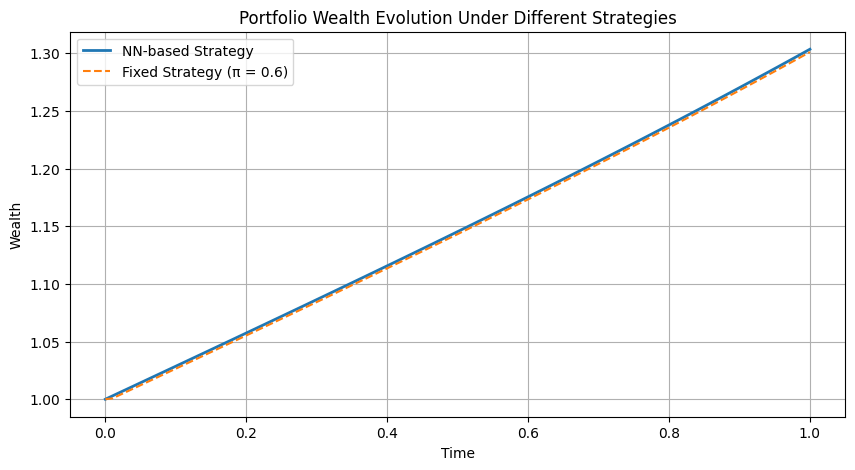

In [ ]:
import torch
import torch.nn as nn
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'SPY']
raw_data = yf.download(tickers, start="2020-01-01", end="2024-12-31", group_by='ticker', auto_adjust=False)
data = pd.concat([raw_data[ticker]['Adj Close'].rename(ticker) for ticker in tickers], axis=1)

returns = data[tickers].pct_change().dropna()
benchmark_returns = data['SPY'].pct_change().dropna()

# Convert to torch
returns_tensor = torch.tensor(returns.values, dtype=torch.float32)
benchmark_tensor = torch.tensor(benchmark_returns.values, dtype=torch.float32)

n_assets = len(tickers)
window_size = 252
rebalance_interval = 20
initial_capital = 100_000

# Define PortfolioNet
class PortfolioNet(nn.Module):
    def __init__(self, n_assets):
        super().__init__()
        self.raw_weights = nn.Parameter(torch.randn(n_assets))

    def forward(self):
        return torch.softmax(self.raw_weights, dim=0)

# Define LSTM Predictor
class LSTMReturnPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.linear(h_n.squeeze(0))

# Loss function
def pinn_loss(model, mu, cov, ret_series, prev_weights, target_return=0.15,
              lambda_ret=1000, lambda_tc=10, lambda_l2=0.1, lambda_down=50):
    w = model()
    risk = torch.matmul(w, torch.matmul(cov, w))
    ret_constraint = torch.relu(target_return - torch.dot(mu, w))
    tc = torch.sum(torch.abs(w - prev_weights)) if prev_weights is not None else 0
    l2 = torch.sum(model.raw_weights**2)
    daily_returns = ret_series @ w
    downside = torch.mean(torch.relu(-daily_returns)**2)
    loss = risk + lambda_ret * ret_constraint**2 + lambda_tc * tc + lambda_l2 * l2 + lambda_down * downside
    return loss, w.detach(), torch.dot(mu, w).item(), torch.sqrt(risk).item()

# Initialize models
portfolio_model = PortfolioNet(n_assets)
lstm_model = LSTMReturnPredictor(n_assets)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
portfolio_optimizer = torch.optim.Adam(portfolio_model.parameters(), lr=0.01)

portfolio_values = [initial_capital]
benchmark_values = [initial_capital]
weights_history, returns_history, volatility_history, losses = [], [], [], []

current_index = window_size
prev_weights = None
data_dates = returns.index

while current_index + rebalance_interval < len(returns_tensor):
    ret_window = returns_tensor[current_index - window_size:current_index]
    x_seq = ret_window.unsqueeze(0)  # [1, T, n_assets]

    # Train LSTM
    for _ in range(100):
        lstm_optimizer.zero_grad()
        mu_pred = lstm_model(x_seq)
        loss = -mu_pred.mean()
        loss.backward()
        lstm_optimizer.step()

    # Detach to prevent backward-through-graph error
    mu = lstm_model(x_seq).squeeze(0).detach() * 252
    cov = torch.cov(ret_window.T) * 252

    # Train portfolio model
    for _ in range(300):
        portfolio_optimizer.zero_grad()
        loss, w_opt, ret, vol = pinn_loss(portfolio_model, mu, cov, ret_window, prev_weights)
        loss.backward()
        portfolio_optimizer.step()

    weights_history.append(w_opt.numpy())
    returns_history.append(ret)
    volatility_history.append(vol)
    losses.append(loss.item())

    prices_next = data[tickers].iloc[current_index:current_index + rebalance_interval]
    returns_next = prices_next.pct_change().dropna().values
    port_returns = returns_next @ w_opt.numpy()

    for r in port_returns:
        portfolio_values.append(portfolio_values[-1] * (1 + r))

    bench_returns = benchmark_returns.iloc[current_index:current_index + rebalance_interval].values
    for r in bench_returns:
        benchmark_values.append(benchmark_values[-1] * (1 + r))

    current_index += rebalance_interval
    prev_weights = w_opt
# --- Compute Optimal Strategy from Neural Network Derivatives ---

def compute_optimal_strategy(model, t, x, mu=0.1, r=0.03, sigma=0.2, gamma=3.0):
    t_tensor = torch.tensor([[t]], dtype=torch.float32, requires_grad=True).to(device)
    x_tensor = torch.tensor([[x]], dtype=torch.float32, requires_grad=True).to(device)

    V = model(t_tensor, x_tensor)
    V_x = torch.autograd.grad(V, x_tensor, create_graph=True)[0]
    V_xx = torch.autograd.grad(V_x, x_tensor, create_graph=True)[0]

    pi_star = - (V_x / (V_xx + 1e-8)) * ((mu - r) / sigma**2)
    return pi_star.item()
# --- Simulate Wealth Path Using Neural Network Strategy ---

def simulate_wealth(model, x0=1.0, T=1.0, steps=100, mu=0.1, r=0.03, sigma=0.2, gamma=3.0):
    dt = T / steps
    times = np.linspace(0, T, steps + 1)
    wealth_nn = [x0]
    wealth_fixed = [x0]

    for i in range(steps):
        t = times[i]
        x = wealth_nn[-1]

        # Neural net-derived control
        pi = compute_optimal_strategy(model, t, x, mu, r, sigma, gamma)

        # Euler step for wealth
        dx_nn = x * (r + pi * (mu - r)) * dt
        dx_fixed = x * (r + 0.6 * (mu - r)) * dt  # fixed strategy example

        wealth_nn.append(x + dx_nn)
        wealth_fixed.append(x + dx_fixed)

    return times, wealth_nn, wealth_fixed
# --- Plot Simulated Wealth Paths ---

times, wealth_nn, wealth_fixed = simulate_wealth(model)

plt.figure(figsize=(10, 5))
plt.plot(times, wealth_nn, label='NN-based Strategy', linewidth=2)
plt.plot(times, wealth_fixed, label='Fixed Strategy (π = 0.6)', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Wealth")
plt.title("Portfolio Wealth Evolution Under Different Strategies")
plt.legend()
plt.grid(True)
plt.show()



**This cell visualizes the optimized portfolio's performance relative to the SPY benchmark. It plots the portfolio value, cumulative returns, drawdowns, weight allocations, and Sharpe ratio evolution over time. It also logs key metrics to a CSV and presents the correlation heatmap of asset returns to highlight diversification potential.**

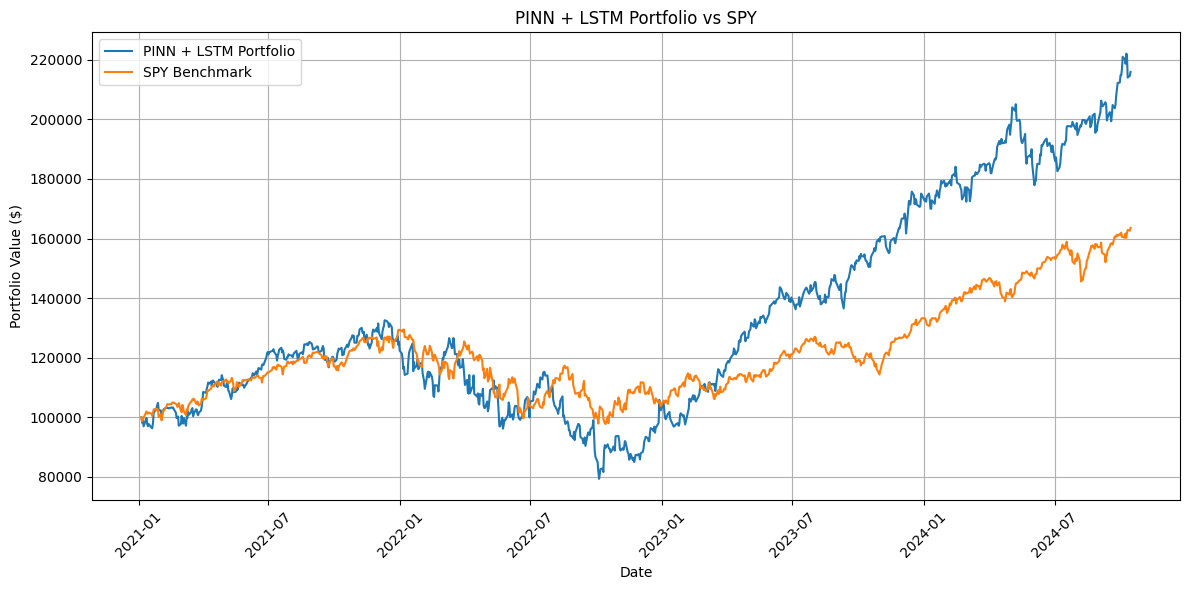

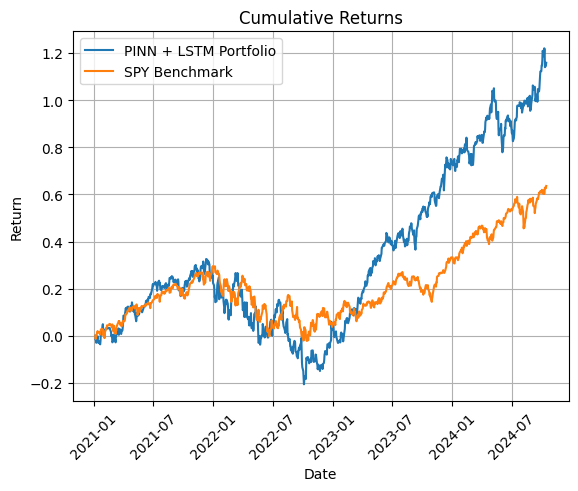

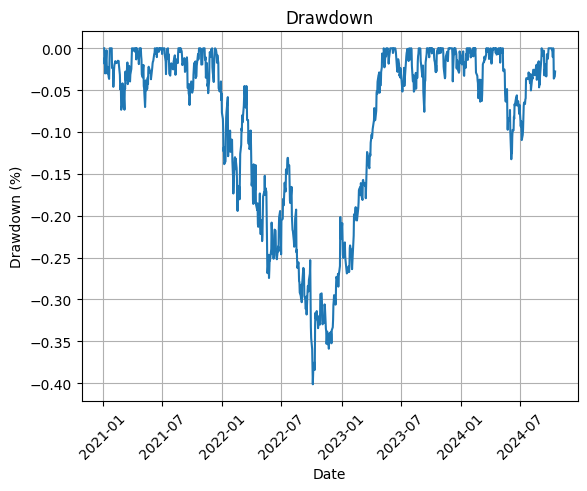

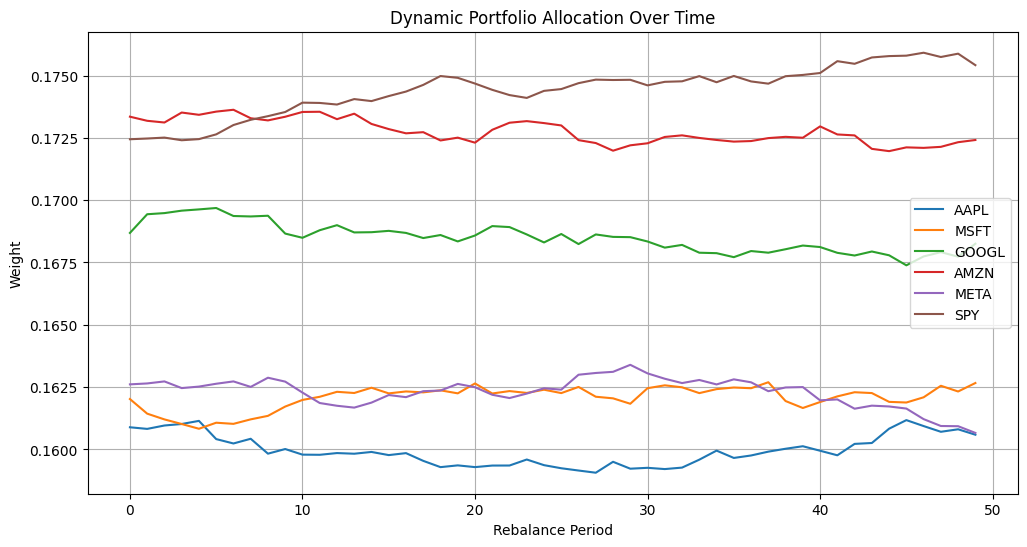

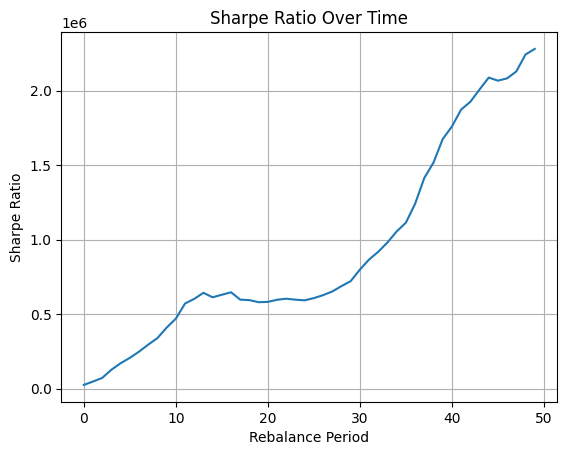

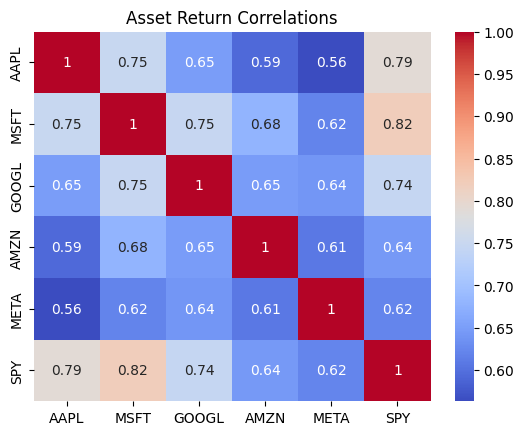

In [ ]:
# Plot Portfolio vs Benchmark
plot_dates = data_dates[window_size+1:window_size+1+len(portfolio_values)]
plt.figure(figsize=(12, 6))
plt.plot(plot_dates, portfolio_values, label="PINN + LSTM Portfolio")
plt.plot(plot_dates, benchmark_values[:len(plot_dates)], label="SPY Benchmark")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("PINN + LSTM Portfolio vs SPY")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cumulative returns
p_returns = np.array(portfolio_values) / initial_capital - 1
b_returns = np.array(benchmark_values[:len(p_returns)]) / initial_capital - 1

plt.plot(plot_dates, p_returns, label='PINN + LSTM Portfolio')
plt.plot(plot_dates, b_returns, label='SPY Benchmark')
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Drawdown
def compute_drawdown(values):
    peak = np.maximum.accumulate(values)
    drawdown = (values - peak) / peak
    return drawdown

drawdown = compute_drawdown(np.array(portfolio_values))
plt.plot(plot_dates, drawdown)
plt.title("Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Weight allocation plot
weights_history = np.array(weights_history)
plt.figure(figsize=(12, 6))
for i in range(n_assets):
    plt.plot(weights_history[:, i], label=tickers[i])
plt.legend()
plt.title("Dynamic Portfolio Allocation Over Time")
plt.xlabel("Rebalance Period")
plt.ylabel("Weight")
plt.grid(True)
plt.show()

# Sharpe Ratio
returns_history = np.array(returns_history)
volatility_history = np.array(volatility_history)
sharpe_ratios = returns_history / volatility_history
plt.plot(sharpe_ratios)
plt.title("Sharpe Ratio Over Time")
plt.xlabel("Rebalance Period")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()

# Save logs
log_df = pd.DataFrame(weights_history, columns=tickers)
log_df['Sharpe'] = sharpe_ratios
log_df['Expected Return'] = returns_history
log_df['Volatility'] = volatility_history
log_df['Loss'] = losses
log_df.to_csv("pinn_lstm_portfolio_log.csv")

# Correlation Heatmap of Assets
sns.heatmap(returns.corr(), annot=True, cmap="coolwarm")
plt.title("Asset Return Correlations")
plt.show()

Text(0.5, 1.0, 'Training Loss over Time')

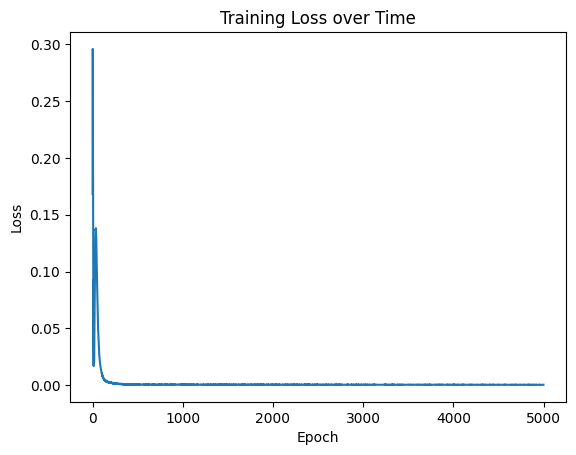

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Time')


#**PINN Training for Solving the HJB Equation in Optimal Portfolio Control**#

**This cell defines and trains a Physics-Informed Neural Network (PINN) to approximate the value function
𝑉
(
𝑡
,
𝑥
)
V(t,x) that solves the Hamilton-Jacobi-Bellman (HJB) equation for a utility-maximizing investor. It calculates the HJB residual using automatic differentiation, enforces the terminal condition
𝑉
(
𝑇
,
𝑥
)
=
𝑈
(
𝑥
)
V(T,x)=U(x), and trains the model to minimize both components. Loss evolution is plotted for diagnostics.**

Epoch 0, Loss: 0.16805, HJB Loss: 0.00335, Terminal Loss: 0.16470
Epoch 500, Loss: 0.00064, HJB Loss: 0.00006, Terminal Loss: 0.00058
Epoch 1000, Loss: 0.00059, HJB Loss: 0.00003, Terminal Loss: 0.00056
Epoch 1500, Loss: 0.00055, HJB Loss: 0.00002, Terminal Loss: 0.00053
Epoch 2000, Loss: 0.00051, HJB Loss: 0.00002, Terminal Loss: 0.00049
Epoch 2500, Loss: 0.00044, HJB Loss: 0.00002, Terminal Loss: 0.00042
Epoch 3000, Loss: 0.00055, HJB Loss: 0.00002, Terminal Loss: 0.00053
Epoch 3500, Loss: 0.00044, HJB Loss: 0.00002, Terminal Loss: 0.00042
Epoch 4000, Loss: 0.00055, HJB Loss: 0.00002, Terminal Loss: 0.00053
Epoch 4500, Loss: 0.00043, HJB Loss: 0.00002, Terminal Loss: 0.00041


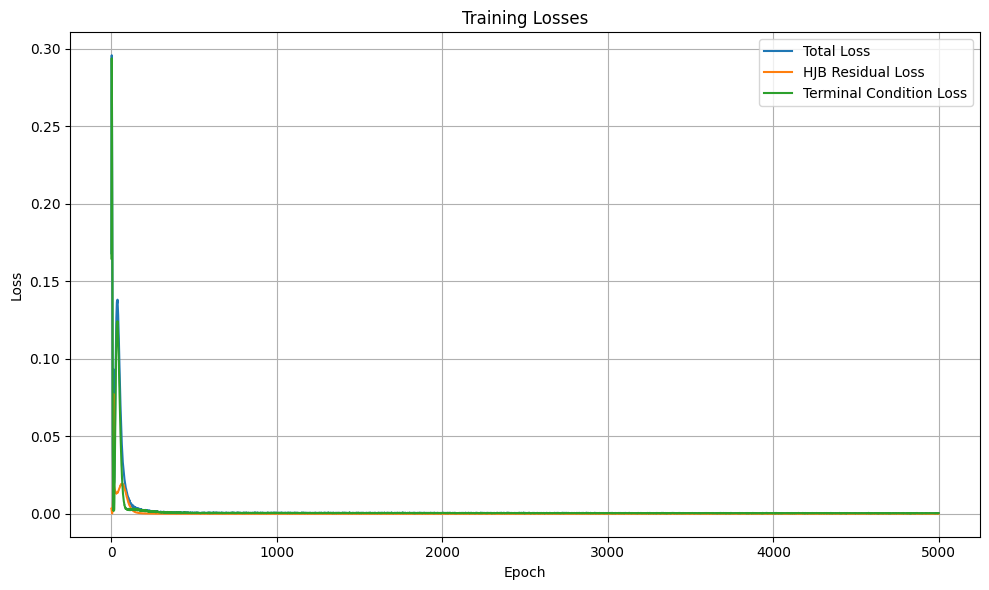

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 0.1       # Expected return
r = 0.03       # Risk-free rate
sigma = 0.2    # Volatility
gamma = 3.0    # Risk aversion
T = 1.0        # Time horizon
device = 'cuda' if torch.cuda.is_available() else 'cpu'
losses = []
hjb_losses = []
terminal_losses = []

# Utility function
def utility(x):
    return (x ** (1 - gamma)) / (1 - gamma)

# PINN for V(t, x)
class ValueFunctionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t, x):
        input_tensor = torch.cat([t, x], dim=1)
        return self.net(input_tensor)

# Derivatives
def gradients(V, t, x):
    dV = autograd.grad(V, [t, x], grad_outputs=torch.ones_like(V), create_graph=True)
    dV_t = dV[0]
    dV_x = dV[1]
    d2V_x = autograd.grad(dV_x, x, grad_outputs=torch.ones_like(dV_x), create_graph=True)[0]
    return dV_t, dV_x, d2V_x

# HJB residual
def hjb_residual(model, t, x):
    V = model(t, x)
    dV_t, dV_x, d2V_x = gradients(V, t, x)

    pi_star = -(mu - r) / sigma**2 * dV_x / (d2V_x + 1e-6)
    H = pi_star * (mu - r) * dV_x + 0.5 * (pi_star**2) * sigma**2 * d2V_x
    drift = r * x * dV_x

    residual = dV_t + H + drift
    return residual

# Training
model = ValueFunctionNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 5000
batch_size = 1024

for epoch in range(n_epochs):
    # Sample t ∈ [0, T), x ∈ [1, 5]
    t = torch.rand(batch_size, 1, device=device) * T
    x = 1 + 4 * torch.rand(batch_size, 1, device=device)

    t.requires_grad = True
    x.requires_grad = True

    residual = hjb_residual(model, t, x)

    # Terminal loss: V(T, x) = U(x)
    x_terminal = 1 + 4 * torch.rand(batch_size, 1, device=device)
    t_terminal = torch.full_like(x_terminal, T, device=device)
    target_terminal = utility(x_terminal)

    pred_terminal = model(t_terminal, x_terminal)
    loss_hjb = torch.mean(residual**2)
    loss_terminal = torch.mean((pred_terminal - target_terminal) ** 2)
    loss = loss_hjb + loss_terminal

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    hjb_losses.append(loss_hjb.item())
    terminal_losses.append(loss_terminal.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}, HJB Loss: {loss_hjb.item():.5f}, Terminal Loss: {loss_terminal.item():.5f}")
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Total Loss')
plt.plot(hjb_losses, label='HJB Residual Loss')
plt.plot(terminal_losses, label='Terminal Condition Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Learned vs Exact Value Function

**Description:**
Here we plot the value function learned by PINN and compare it to the exact analytical solution using contour plots over time and wealth.


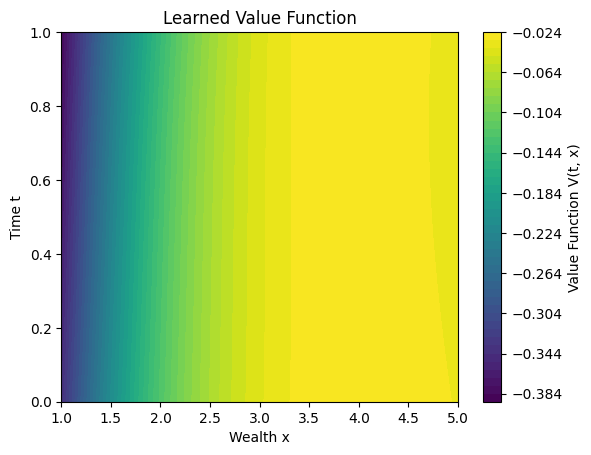

In [ ]:
# Grid for plotting
t_grid, x_grid = torch.meshgrid(
    torch.linspace(0, T, 100),
    torch.linspace(1, 5, 100),
    indexing='ij'
)
with torch.no_grad():
    t_plot = t_grid.reshape(-1, 1).to(device)
    x_plot = x_grid.reshape(-1, 1).to(device)
    V_plot = model(t_plot, x_plot).cpu().numpy().reshape(100, 100)

plt.contourf(x_grid.numpy(), t_grid.numpy(), V_plot, levels=50, cmap='viridis')
plt.colorbar(label='Value Function V(t, x)')
plt.xlabel("Wealth x")
plt.ylabel("Time t")
plt.title("Learned Value Function")
plt.show()

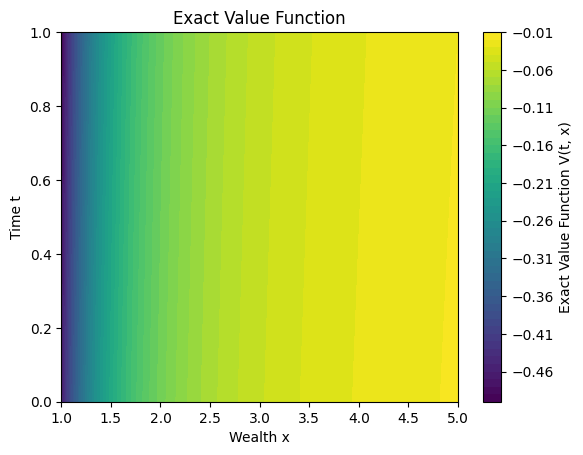

In [ ]:
# Compute exact solution
def exact_value_function(t, x, mu=0.1, r=0.03, sigma=0.2, gamma=3.0, T=1.0):
    A = (1 - gamma) / (2 * gamma**2) * ((mu - r) / sigma) ** 2 + r * (1 - gamma)
    V = (x ** (1 - gamma)) / (1 - gamma) * np.exp(A * (T - t))
    return V

# Same grid used for plotting
t_vals = t_grid.numpy().reshape(-1, 1)
x_vals = x_grid.numpy().reshape(-1, 1)
V_exact_flat = exact_value_function(t_vals, x_vals, mu=mu, r=r, sigma=sigma, gamma=gamma, T=T)
V_exact = V_exact_flat.reshape(100, 100)

# Plot Exact Solution
plt.contourf(x_grid.numpy(), t_grid.numpy(), V_exact, levels=50, cmap='viridis')
plt.colorbar(label='Exact Value Function V(t, x)')
plt.xlabel("Wealth x")
plt.ylabel("Time t")
plt.title("Exact Value Function")
plt.show()

#**PINN vs Exact Solution: Error Visualization**#

**This cell compares the PINN-learned value function to the analytical solution by plotting contour maps of absolute and relative errors. It also reports the mean and maximum relative errors as summary accuracy metrics.**


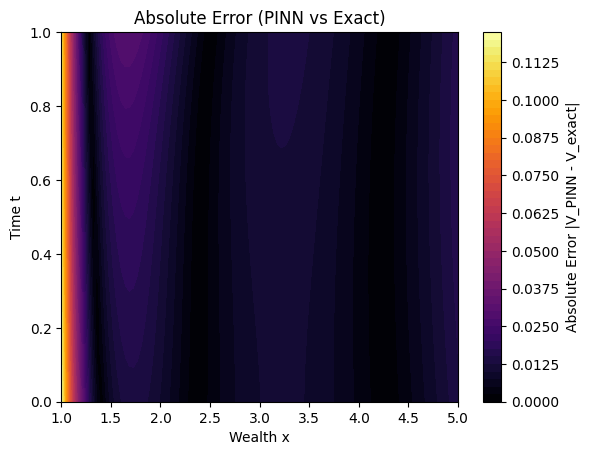

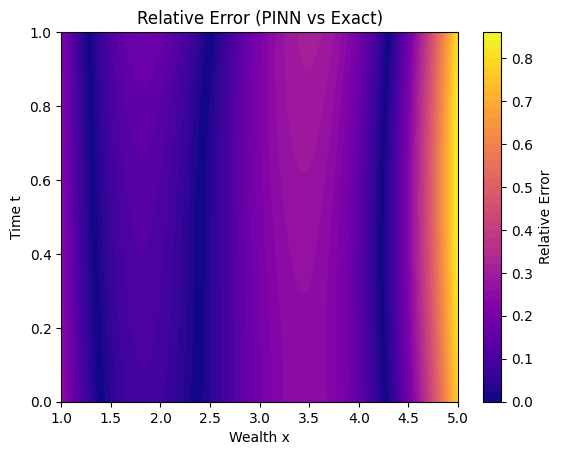

Mean Relative Error: 0.18596
Max Relative Error: 0.85598


In [ ]:
# Difference map
error = np.abs(V_plot - V_exact)
rel_error = error / (np.abs(V_exact) + 1e-8)

# Absolute error
plt.contourf(x_grid.numpy(), t_grid.numpy(), error, levels=50, cmap='inferno')
plt.colorbar(label='Absolute Error |V_PINN - V_exact|')
plt.xlabel("Wealth x")
plt.ylabel("Time t")
plt.title("Absolute Error (PINN vs Exact)")
plt.show()

# Relative error
plt.contourf(x_grid.numpy(), t_grid.numpy(), rel_error, levels=50, cmap='plasma')
plt.colorbar(label='Relative Error')
plt.xlabel("Wealth x")
plt.ylabel("Time t")
plt.title("Relative Error (PINN vs Exact)")
plt.show()

# Optional: Compute global metrics
mean_rel_error = np.mean(rel_error)
max_rel_error = np.max(rel_error)
print(f"Mean Relative Error: {mean_rel_error:.5f}")
print(f"Max Relative Error: {max_rel_error:.5f}")

## 📊 Numerical Accuracy Comparison

In [ ]:

from sklearn.metrics import mean_squared_error

# Flatten for comparison
V_plot_flat = V_plot.flatten()
V_exact_flat = V_exact.flatten()

rmse = np.sqrt(mean_squared_error(V_exact_flat, V_plot_flat))
max_error = np.max(np.abs(V_plot_flat - V_exact_flat))

print(f"RMSE between model and exact solution: {rmse:.6f}")
print(f"Maximum absolute error: {max_error:.6f}")


RMSE between model and exact solution: 0.020666
Maximum absolute error: 0.121446


#**Finite Difference Method for Solving HJB Equation**#

**Here we implement a backward-time finite difference scheme to numerically solve the HJB equation for portfolio optimization. Terminal utility is used as the final condition.**

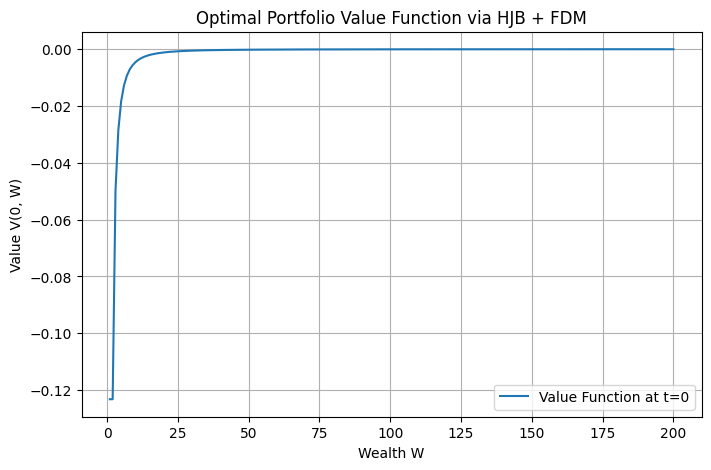

In [ ]:
# HJB Equation Solver via Finite Difference Method for Dynamic Portfolio Optimization

import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1.0           # Time horizon (1 year)
r = 0.03          # Risk-free rate
mu = 0.08         # Expected return of risky asset
sigma = 0.2       # Volatility of risky asset
gamma = 3.0       # Risk aversion (CRRA utility)

# Discretization
dt = 0.01
N = int(T / dt)

dW = 1.0
W_min = 1.0
W_max = 200.0
M = int((W_max - W_min) / dW)

t = np.linspace(0, T, N+1)
W = np.linspace(W_min, W_max, M+1)

# Initialize value function V(t, W)
V = np.zeros((N+1, M+1))

# Final condition: CRRA utility at T
if gamma != 1:
    V[-1, :] = (W ** (1 - gamma)) / (1 - gamma)
else:
    V[-1, :] = np.log(W)

# Backward in time
for n in reversed(range(N)):
    for j in range(1, M):
        # First and second derivatives
        V_W = (V[n+1, j+1] - V[n+1, j-1]) / (2 * dW)
        V_WW = (V[n+1, j+1] - 2 * V[n+1, j] + V[n+1, j-1]) / (dW ** 2)

        Wj = W[j]

        # Optimal control
        if V_WW != 0:
            pi_star = -(mu - r) * V_W / (sigma**2 * Wj * V_WW)
        else:
            pi_star = 0.0

        # HJB update
        drift_term = pi_star * (mu - r) * Wj * V_W
        diff_term = 0.5 * (pi_star ** 2) * (sigma ** 2) * (Wj ** 2) * V_WW
        bank_term = r * Wj * V_W

        V[n, j] = V[n+1, j] + dt * (drift_term + diff_term + bank_term)

    # Boundary conditions
    V[n, 0] = V[n, 1]  # Neumann BC at W_min
    V[n, -1] = V[n, -2]  # Neumann BC at W_max

# Plot the value function at t = 0
plt.figure(figsize=(8,5))
plt.plot(W, V[0, :], label=f"Value Function at t=0")
plt.xlabel("Wealth W")
plt.ylabel("Value V(0, W)")
plt.title("Optimal Portfolio Value Function via HJB + FDM")
plt.legend()
plt.grid(True)
plt.show()


#**Evaluate and Compare PINN to FDM Solution**#

#Defining PINN Model for HJB Equation#

Here we define a simple feedforward neural network to approximate the value function V(t, w). This network will be trained to minimize the residual of the HJB PDE and match the terminal utility condition.

#Training the PINN on HJB Equation#

This cell trains the neural network by enforcing the PDE residual on interior points and the terminal utility condition at the final time. Loss values are printed during training to monitor progress.

#Evaluate and Compare PINN to FDM Solution#

We evaluate the trained PINN at t=0 and compare its output against the finite difference solution. The plot shows how well the PINN matches the classical numerical method.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Problem parameters
T = 1.0              # final time
sigma = 0.2          # volatility
mu = 0.1             # expected return
r = 0.03             # risk-free rate
gamma = 0.5          # risk aversion
W_max = 5            # maximum wealth

# Discretization
N = 100              # time steps (FDM)
M = 100              # wealth grid points
dt = T / N
W = np.linspace(1e-3, W_max, M)
dW = W[1] - W[0]


In [ ]:
# Finite Difference Method (Backward Euler)
V_fdm = np.zeros((N + 1, M))
V_fdm[-1, :] = W**(1 - gamma) / (1 - gamma)  # terminal condition at t = T

for n in reversed(range(N)):
    for i in range(1, M - 1):
        Vx = (V_fdm[n+1, i+1] - V_fdm[n+1, i-1]) / (2*dW)
        Vxx = (V_fdm[n+1, i+1] - 2*V_fdm[n+1, i] + V_fdm[n+1, i-1]) / (dW**2)
        pi_star = (mu - r) * Vx / (sigma**2 * Vxx + 1e-6)
        H = r * W[i] * Vx + 0.5 * sigma**2 * pi_star**2 * W[i]**2 * Vxx
        V_fdm[n, i] = V_fdm[n+1, i] - dt * H


In [ ]:
# Define PINN model
class HJBNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t, w):
        x = torch.stack([t, w], dim=1)
        return self.net(x)

# Initialize
model = HJBNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train
for epoch in range(5000):
    # Interior points (PDE residual)
    t_interior = torch.rand(1000, requires_grad=True) * T
    w_interior = torch.rand(1000, requires_grad=True) * W_max

    V_interior = model(t_interior, w_interior).squeeze()
    grads = torch.autograd.grad(V_interior.sum(), [t_interior, w_interior], create_graph=True)
    Vt, Vw = grads
    Vww = torch.autograd.grad(Vw.sum(), w_interior, create_graph=True)[0]

    pi_star = (mu - r) * Vw / (sigma**2 * Vww + 1e-6)
    H = r * w_interior * Vw + 0.5 * sigma**2 * pi_star**2 * w_interior**2 * Vww
    pde_residual = Vt + H
    loss_pde = (pde_residual**2).mean()

    # Terminal condition
    w_terminal = torch.rand(1000, requires_grad=False) * W_max
    t_terminal = torch.ones_like(w_terminal) * T
    V_terminal_pred = model(t_terminal, w_terminal).squeeze()
    V_terminal_true = w_terminal**(1 - gamma) / (1 - gamma)
    loss_terminal = ((V_terminal_pred - V_terminal_true)**2).mean()

    # Total loss
    loss = loss_pde + loss_terminal

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss PDE: {loss_pde.item():.5e}, Loss Terminal: {loss_terminal.item():.5e}")


Epoch 0, Loss PDE: 1.58122e-02, Loss Terminal: 9.47160e+00
Epoch 500, Loss PDE: 2.88994e+03, Loss Terminal: 1.01309e+01
Epoch 1000, Loss PDE: 9.56387e+03, Loss Terminal: 1.00716e+01
Epoch 1500, Loss PDE: 1.57388e+00, Loss Terminal: 9.62200e+00
Epoch 2000, Loss PDE: 1.46776e+01, Loss Terminal: 9.51954e+00
Epoch 2500, Loss PDE: 1.47699e+01, Loss Terminal: 9.32528e+00
Epoch 3000, Loss PDE: 2.21728e+00, Loss Terminal: 8.61806e+00
Epoch 3500, Loss PDE: 2.53849e+01, Loss Terminal: 8.55753e+00
Epoch 4000, Loss PDE: 1.10200e+01, Loss Terminal: 8.35627e+00
Epoch 4500, Loss PDE: 3.53185e-01, Loss Terminal: 7.99637e+00


#Compute Relative L2 Error Between FDM and PINN#
This cell computes the relative L2 norm between the FDM solution and the PINN output at time
𝑡
=
0.

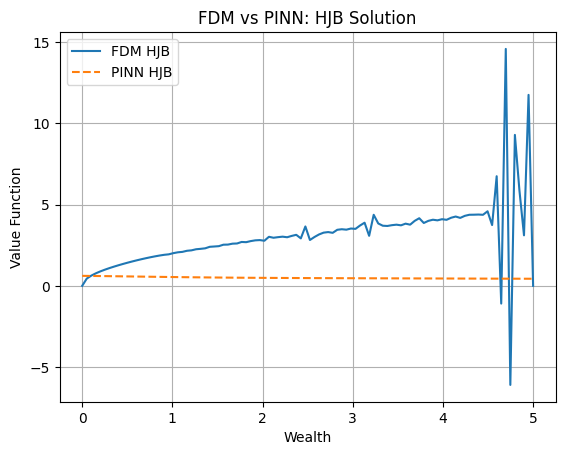

Relative L2 Error between FDM and PINN: 9.01462e-01


In [ ]:
# Evaluate PINN
model.eval()
with torch.no_grad():
    w_test = torch.linspace(1e-3, W_max, M)
    t_test = torch.zeros_like(w_test)
    v_pred = model(t_test, w_test).squeeze().numpy()

# Plot comparison
plt.plot(W, V_fdm[0, :], label='FDM HJB')
plt.plot(w_test.numpy(), v_pred, label='PINN HJB', linestyle='--')
plt.title('FDM vs PINN: HJB Solution')
plt.xlabel('Wealth')
plt.ylabel('Value Function')
plt.legend()
plt.grid(True)
plt.show()

# Compute relative L2 error
fdm_solution = V_fdm[0, :]
pinn_solution = v_pred
l2_error = np.linalg.norm(fdm_solution - pinn_solution) / np.linalg.norm(fdm_solution)
print(f"Relative L2 Error between FDM and PINN: {l2_error:.5e}")


#Alternate FDM Implementation for HJB#

We implement a slightly modified FDM solver with different boundary handling to check the consistency.

Epoch 0, Loss: 5.10832e+01
Epoch 500, Loss: 1.13525e+01
Epoch 1000, Loss: 1.05012e+01
Epoch 1500, Loss: 1.03300e+01
Epoch 2000, Loss: 1.01349e+01
Epoch 2500, Loss: 1.01527e+01
Epoch 3000, Loss: 1.01550e+01
Epoch 3500, Loss: 1.02034e+01
Epoch 4000, Loss: 1.00646e+01
Epoch 4500, Loss: 1.00136e+01


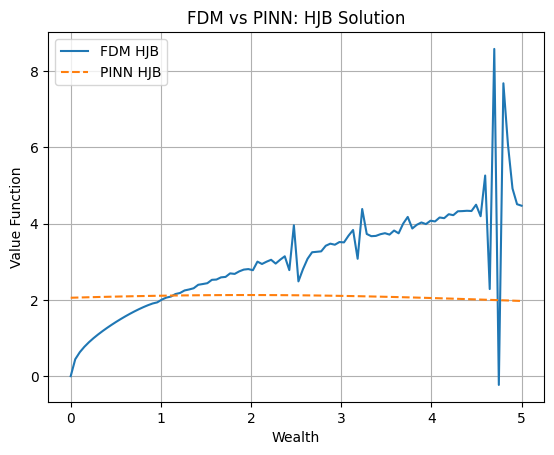

Relative L2 Error between FDM and PINN: 5.09842e-01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Parameters
T = 1.0
N = 100   # time steps
M = 100   # wealth grid points
sigma = 0.2
mu = 0.1
r = 0.03
gamma = 0.5

# Discretization
dt = T / N
W_max = 5
W = np.linspace(1e-3, W_max, M)
dW = W[1] - W[0]

# Finite Difference Method (FDM) solution
V = np.zeros((N + 1, M))
V[-1, :] = W**(1 - gamma) / (1 - gamma)  # terminal condition

# Backward in time
for n in reversed(range(N)):
    for i in range(1, M-1):
        Vx = (V[n+1, i+1] - V[n+1, i-1]) / (2*dW)
        Vxx = (V[n+1, i+1] - 2*V[n+1, i] + V[n+1, i-1]) / (dW**2)
        pi_star = (mu - r) * Vx / (sigma**2 * Vxx)
        H = r * W[i] * Vx + 0.5 * sigma**2 * pi_star**2 * W[i]**2 * Vxx
        V[n, i] = V[n+1, i] - dt * H

    # Boundary conditions (IMPORTANT)
    V[n, 0] = 0.0
    V[n, -1] = W_max**(1 - gamma) / (1 - gamma)

# Plot FDM
plt.plot(W, V[0, :], label='FDM HJB')


# Neural Network (PINN) for solving HJB
class HJBNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t, w):
        # Normalize inputs to [-1,1]
        t_scaled = 2.0 * (t / T) - 1.0
        w_scaled = 2.0 * (w / W_max) - 1.0
        x = torch.stack([t_scaled, w_scaled], dim=1)
        return self.net(x)

model = HJBNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training the PINN
for epoch in range(5000):
    t_interior = torch.rand(1000, requires_grad=True)
    w_interior = torch.rand(1000, requires_grad=True) * W_max

    V_pred = model(t_interior, w_interior).squeeze()

    grads = torch.autograd.grad(V_pred.sum(), [t_interior, w_interior], create_graph=True)
    Vt, Vw = grads
    Vww = torch.autograd.grad(Vw.sum(), w_interior, create_graph=True)[0]

    pi_star = (mu - r) * Vw / (sigma**2 * Vww + 1e-6)
    H = r * w_interior * Vw + 0.5 * sigma**2 * pi_star**2 * w_interior**2 * Vww
    pde_residual = Vt + H

    loss_pde = (pde_residual**2).mean()

    # Boundary loss at w = 0
    w0 = torch.zeros(100, requires_grad=True)
    t0 = torch.rand(100, requires_grad=True) * T
    v0 = model(t0, w0).squeeze()
    loss_bc0 = (v0**2).mean()

    # Boundary loss at w = W_max
    w_max = torch.ones(100, requires_grad=True) * W_max
    t_max = torch.rand(100, requires_grad=True) * T
    v_max = model(t_max, w_max).squeeze()
    exact_value = W_max**(1 - gamma) / (1 - gamma)
    loss_bc1 = ((v_max - exact_value)**2).mean()

    loss = loss_pde + loss_bc0 + loss_bc1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

# Evaluate PINN
model.eval()
with torch.no_grad():
    w_test = torch.linspace(1e-3, W_max, M)
    t_test = torch.zeros_like(w_test)
    v_pred = model(t_test, w_test).squeeze().numpy()

    plt.plot(w_test.numpy(), v_pred, '--', label='PINN HJB')

plt.legend()
plt.title('FDM vs PINN: HJB Solution')
plt.xlabel('Wealth')
plt.ylabel('Value Function')
plt.grid(True)
plt.show()

# Compute L2 error between FDM and PINN
fdm_solution = V[0, :]
pinn_solution = v_pred
l2_error = np.linalg.norm(fdm_solution - pinn_solution) / np.linalg.norm(fdm_solution)
print(f"Relative L2 Error between FDM and PINN: {l2_error:.5e}")


**Time Series Analysis**

Calculating daily returns of '*Apple*' stock to prepare for time series analysis by using only the close price and volume.

In [ ]:
import yfinance as yf

# Example: Get data for Apple (AAPL)
data = yf.download('AAPL', start='2020-01-01', end='2024-12-31')

data = data[['Close', 'Volume']]
data['Return'] = data['Close'].pct_change()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Similarly, calculating daily returns of 'Google' stock to prepare for time series analysis.

In [ ]:
import yfinance as yf

# Example: Get data for Apple (GOOG)
data1 = yf.download('GOOG', start='2020-01-01', end='2024-12-31')

data1 = data1[['Close', 'Volume']]
data1['Return'] = data1['Close'].pct_change()



[*********************100%***********************]  1 of 1 completed


Similarly, calculating daily returns of 'Microsoft' stock to prepare for time series analysis.

In [ ]:
import yfinance as yf

# Example: Get data for Microsoft (MSFT)
data2 = yf.download('MSFT', start='2020-01-01', end='2024-12-31')

data2 = data2[['Close', 'Volume']]
data2['Return'] = data2['Close'].pct_change()


[*********************100%***********************]  1 of 1 completed


#Plot AAPL Close Price and Daily Returns#

Here, we visualize the adjusted close prices and daily returns for AAPL to inspect trends and volatility over time. This helps understand return dynamics before modeling.

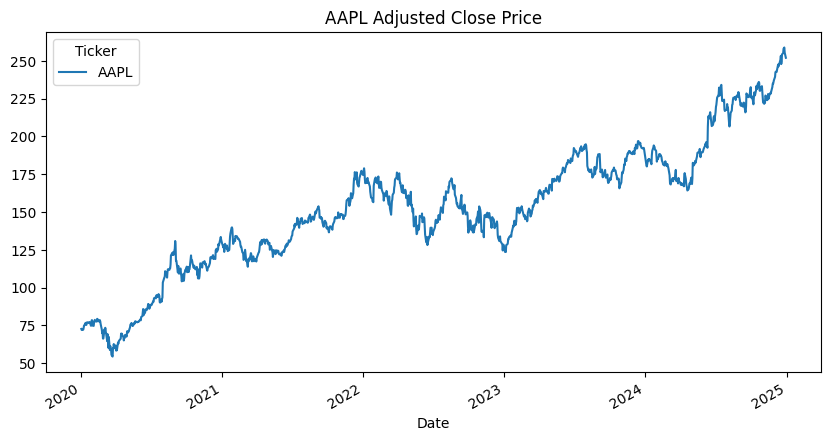

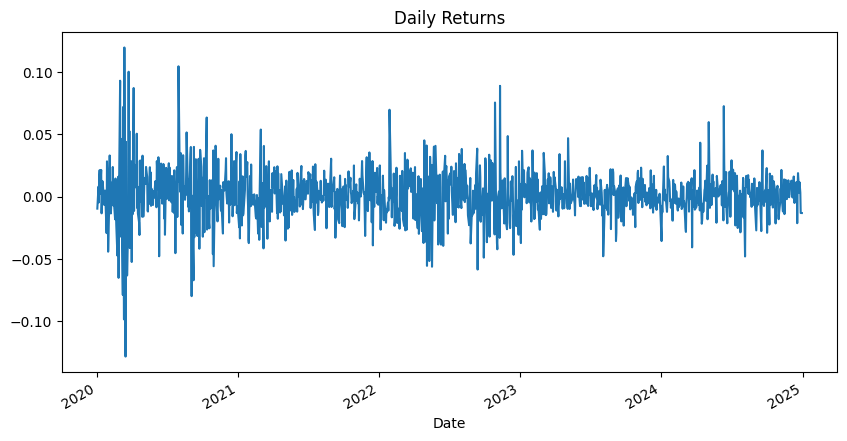

In [ ]:
import matplotlib.pyplot as plt

data['Close'].plot(figsize=(10, 5), title='AAPL Adjusted Close Price')
plt.show()

data['Return'].plot(figsize=(10, 5), title='Daily Returns')
plt.show()


The image shows two time series plots for AAPL (Apple Inc.) stock data:

Top Plot – AAPL Adjusted Close Price:

Displays the adjusted close price of AAPL stock from 2020 to early 2025.

The price trends upward overall, starting from around $60 in 2020 and reaching above $250 by 2025.

Noticeable periods of volatility and correction can be seen, especially in mid-2022 and again in late 2023.

Bottom Plot – Daily Returns:

Shows the daily returns (percentage change) of AAPL stock over the same time period.

The volatility is higher earlier in the timeline, especially around 2020, which is likely linked to the COVID-19 market impact.

Returns appear more stable in later years, though some spikes (both positive and negative) are still visible.

#Plot Google Close Price and Daily Returns#

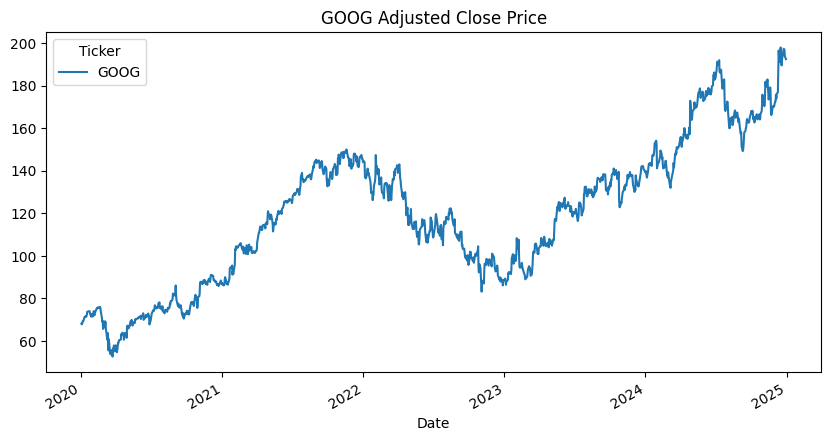

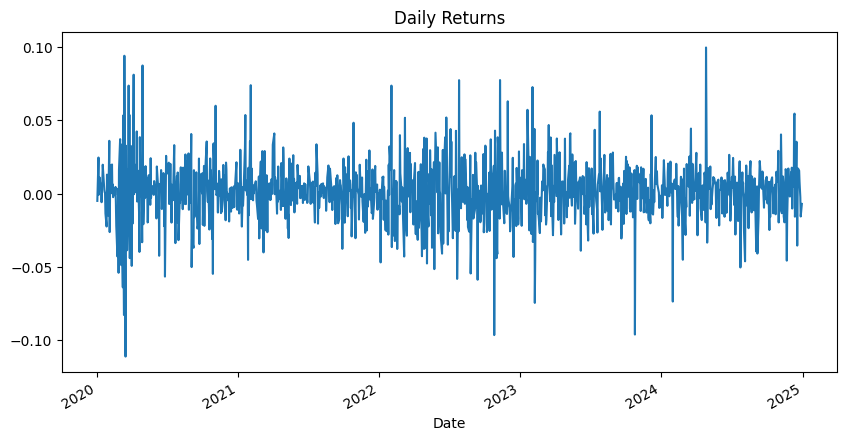

In [ ]:
import matplotlib.pyplot as plt

data1['Close'].plot(figsize=(10, 5), title='GOOG Adjusted Close Price')
plt.show()

data1['Return'].plot(figsize=(10, 5), title='Daily Returns')
plt.show()


#Plot Microsoft Close Price and Daily Returns#

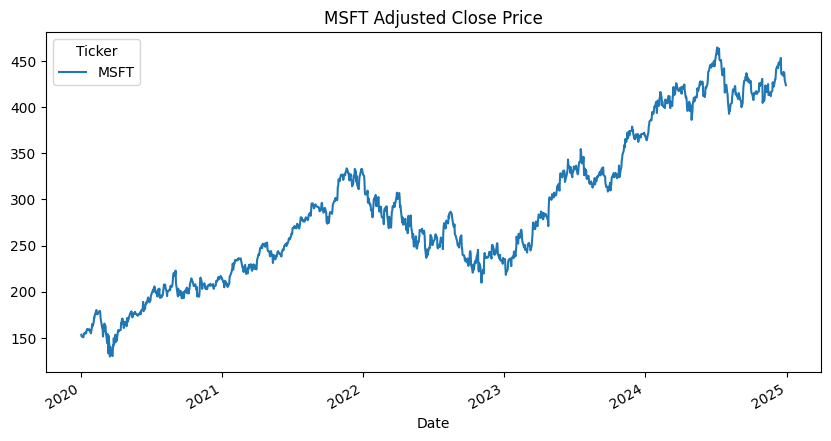

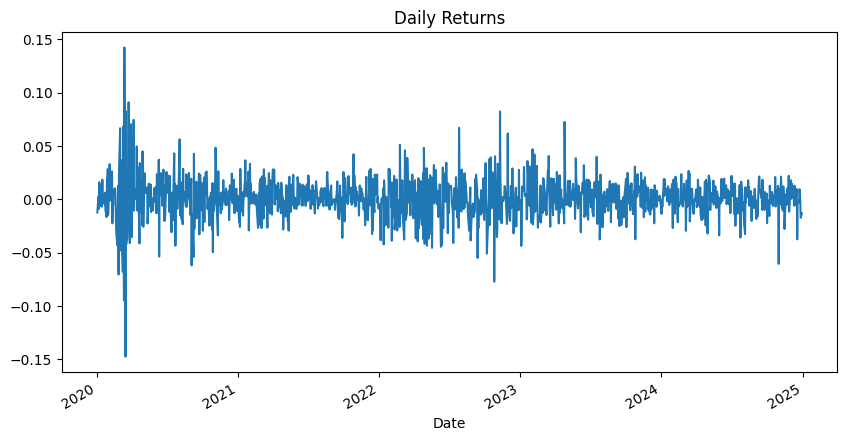

In [ ]:
import matplotlib.pyplot as plt

data2['Close'].plot(figsize=(10, 5), title='MSFT Adjusted Close Price')
plt.show()

data2['Return'].plot(figsize=(10, 5), title='Daily Returns')
plt.show()


This cell applies autocorrelation and partial autocorrelation plots on AAPL returns, followed by an ADF test to check for stationarity.

ADF Statistic: -11.35112021835695
p-value: 9.989426557840665e-21


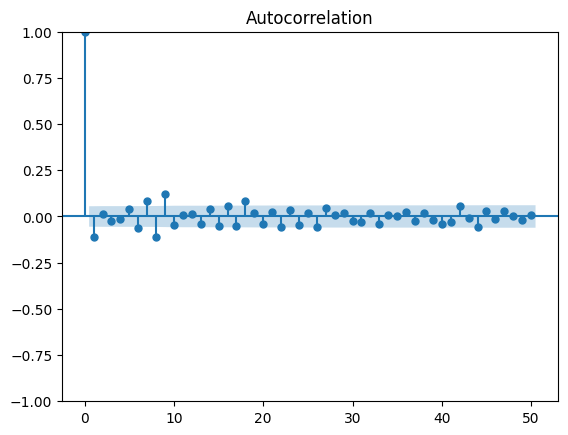

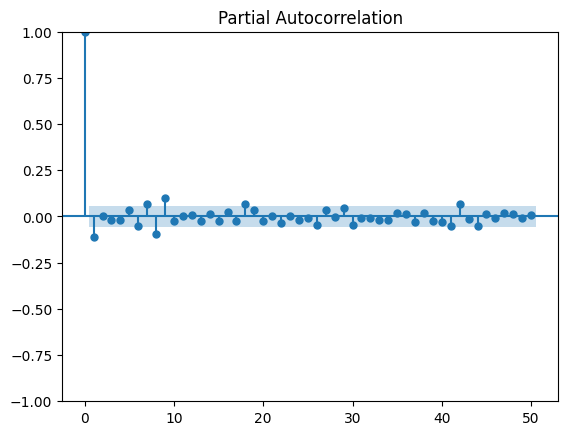

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

plot_acf(data['Return'].dropna(), lags=50)
plot_pacf(data['Return'].dropna(), lags=50)

# Augmented Dickey-Fuller Test
result = adfuller(data['Return'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


#ARIMA(1,0,1) Model for AAPL Returns#

We fit an ARIMA(1,0,1) model to the AAPL return series and print the summary. This helps assess short-term memory in the time series.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Return'].dropna(), order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 1256
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3202.903
Date:                Tue, 22 Apr 2025   AIC                          -6397.805
Time:                        00:57:25   BIC                          -6377.262
Sample:                             0   HQIC                         -6390.084
                               - 1256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.173      0.030    9.76e-05       0.002
ar.L1         -0.1269      0.090     -1.408      0.159      -0.303       0.050
ma.L1         -0.0560      0.096     -0.581      0.5

Download and Preprocess GOOG Data from Alpha Vantage

We use the Alpha Vantage API to get daily adjusted data for GOOG. After renaming columns to match our format, we calculate daily returns and sort the data chronologically.

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

api_key = 'QCQU9KJSUB8FWLRN'
symbol = 'GOOG'

ts = TimeSeries(key=api_key, output_format='pandas')
data1, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

# Rename and calculate returns
data1 = data1.rename(columns={
    '4. close': 'Close',
    '5. volume': 'Volume'
})
data1 = data1[['Close', 'Volume']]
data1['Return'] = data1['Close'].pct_change()

# Sort by date (optional, Alpha Vantage gives newest first)
data1 = data1[::-1]


#ACF, PACF, and ADF Test on GOOG Returns#

ADF Statistic: -53.02321736696459
p-value: 0.0


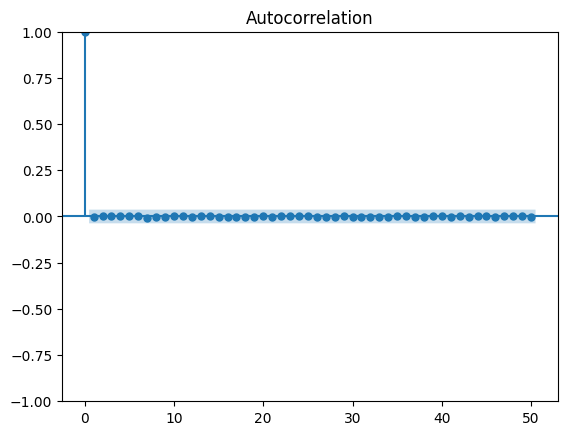

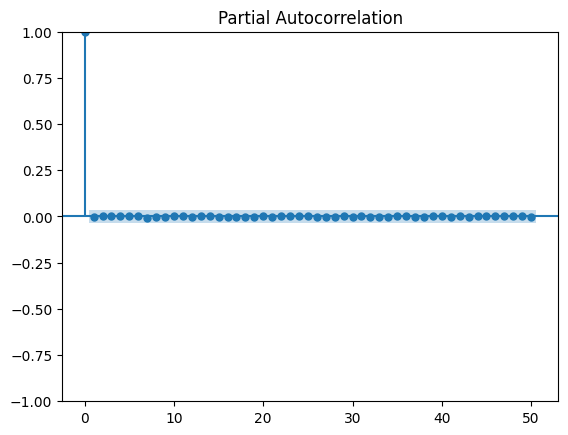

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

plot_acf(data1['Return'].dropna(), lags=50)
plot_pacf(data1['Return'].dropna(), lags=50)

# Augmented Dickey-Fuller Test
result1 = adfuller(data1['Return'].dropna())
print(f'ADF Statistic: {result1[0]}')
print(f'p-value: {result1[1]}')

#ARIMA(1,0,1) Model for GOOG Returns#

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(data1['Return'].dropna(), order=(1, 0, 1))
model_fit1 = model1.fit()
print(model_fit1.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 2797
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1183.775
Date:                Sun, 11 May 2025   AIC                           2375.551
Time:                        06:24:42   BIC                           2399.296
Sample:                             0   HQIC                          2384.123
                               - 2797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.144      0.045      0.964      -0.276       0.289
ar.L1          0.0019    313.520   5.98e-06      1.000    -614.487     614.491
ma.L1         -0.0050    313.521  -1.59e-05      1.0

Download and Preprocess MSFT Data from Alpha Vantage API

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

api_key = 'QCQU9KJSUB8FWLRN'
symbol = 'MSFT'

ts = TimeSeries(key=api_key, output_format='pandas')
data2, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

# Rename and calculate returns
data2 = data2.rename(columns={
    '4. close': 'Close',
    '5. volume': 'Volume'
})
data2 = data2[['Close', 'Volume']]
data2['Return'] = data2['Close'].pct_change()

# Sort by date (optional, Alpha Vantage gives newest first)
data2 = data2[::-1]

#ACF, PACF, and ADF Test on MSFT Returns#

ADF Statistic: -17.7295939656782
p-value: 3.4396170144131145e-30


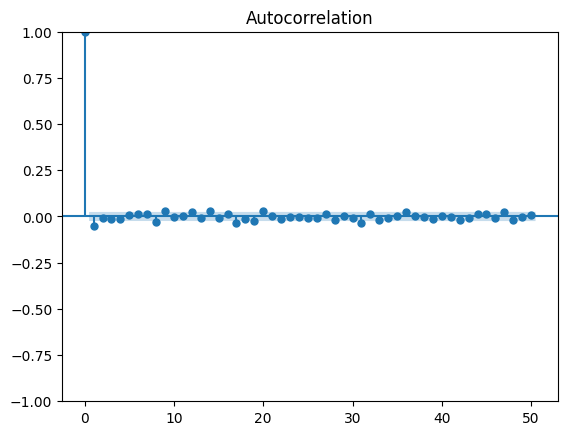

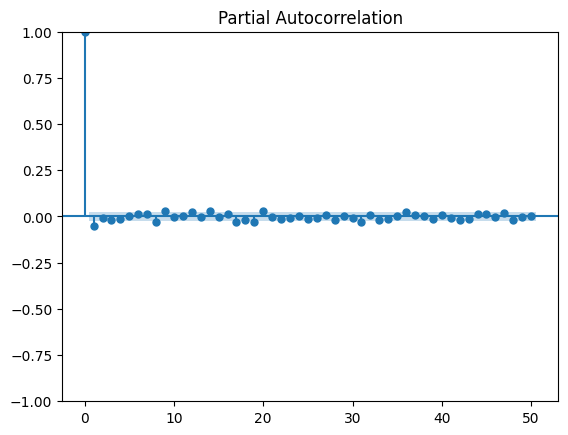

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

plot_acf(data2['Return'].dropna(), lags=50)
plot_pacf(data2['Return'].dropna(), lags=50)

# Augmented Dickey-Fuller Test
result2 = adfuller(data2['Return'].dropna())
print(f'ADF Statistic: {result2[0]}')
print(f'p-value: {result2[1]}')

#ARIMA(1,0,1) Model for MSFT Returns#

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model2 = ARIMA(data2['Return'].dropna(), order=(1, 0, 1))
model_fit2 = model2.fit()
print(model_fit2.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 6419
Model:                 ARIMA(1, 0, 1)   Log Likelihood               15275.185
Date:                Sun, 11 May 2025   AIC                         -30542.370
Time:                        06:19:40   BIC                         -30515.302
Sample:                             0   HQIC                        -30533.002
                               - 6419                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.958e-05      0.000     -0.062      0.950      -0.001       0.001
ar.L1          0.1594      0.163      0.976      0.329      -0.161       0.480
ma.L1         -0.2129      0.163     -1.304      0.1

#Forecast 30-Day Returns for AAPL#

We use the ARIMA model for AAPL to forecast returns for the next 30 days. The forecasted mean series is plotted to visualize short-term expected returns.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: title={'center': '30-Day Return Forecast'}>

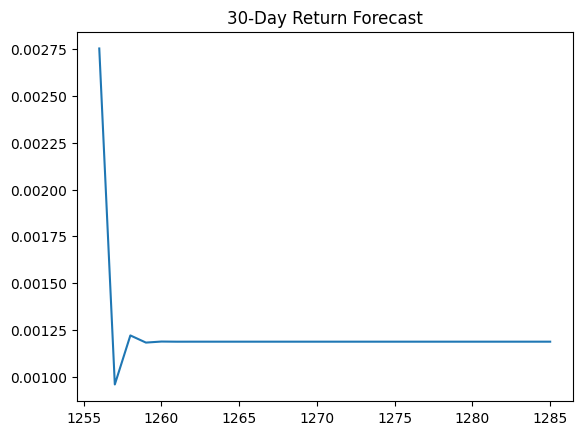

In [ ]:
forecast = model_fit.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

forecast_df['mean'].plot(title='30-Day Return Forecast')



#Forecast 30-Day Returns for GOOG#

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: title={'center': '30-Day Return Forecast'}>

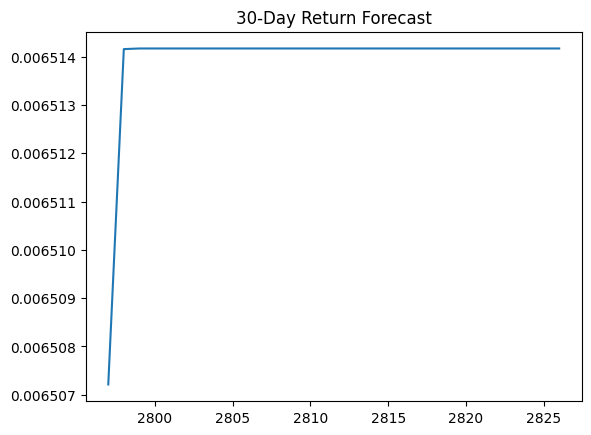

In [ ]:
forecast = model_fit1.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

forecast_df['mean'].plot(title='30-Day Return Forecast')


#Forecast 30-Day Returns for MSFT#

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: title={'center': '30-Day Return Forecast'}>

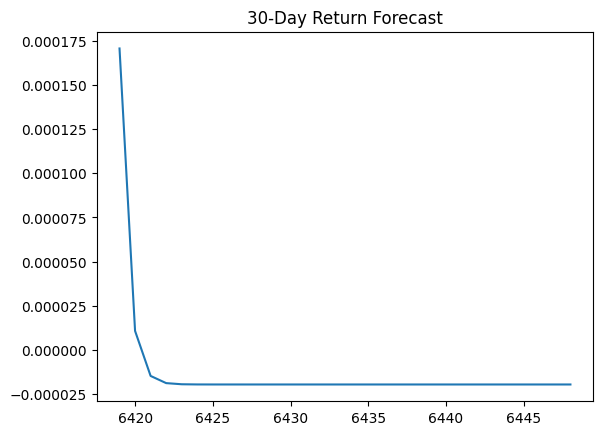

In [ ]:
forecast = model_fit2.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

forecast_df['mean'].plot(title='30-Day Return Forecast')


#Fit GARCH(1,1) Model to AAPL Returns#

We fit a GARCH(1,1) model to AAPL returns (scaled by 100) using the arch package. This captures time-varying volatility and plots conditional variance over time.

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7377.504716066131
Iteration:      2,   Func. Count:     16,   Neg. LLF: 281993.49093769933
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2913.2500633817976
Iteration:      4,   Func. Count:     31,   Neg. LLF: 4868.161458278889
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2512.1442801241956
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2507.1990848276714
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2507.1946393475237
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2507.194577353959
Iteration:      9,   Func. Count:     57,   Neg. LLF: 2507.1945773535754
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2507.194577353959
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9


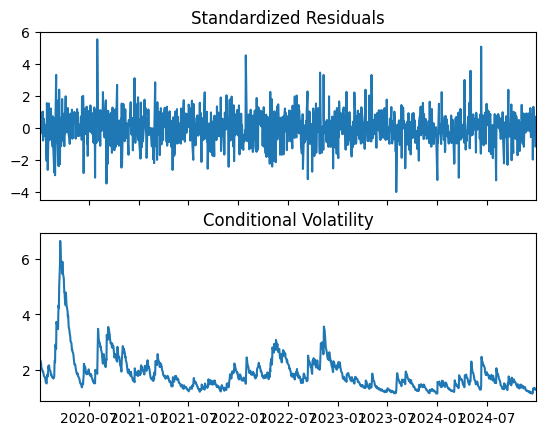

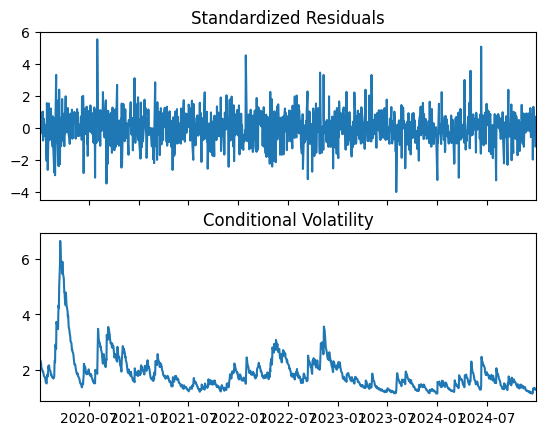

In [ ]:
from arch import arch_model

returns = data['Return'].dropna() * 100  # scale for GARCH
am = arch_model(returns, vol='GARCH', p=1, q=1)
res = am.fit()
res.plot()

#Fit GARCH(1,1) Model to MSFT Returns#

Iteration:      1,   Func. Count:      6,   Neg. LLF: 43046.23572778908
Iteration:      2,   Func. Count:     16,   Neg. LLF: 52760.24503501303
Iteration:      3,   Func. Count:     26,   Neg. LLF: 13521.688778871434
Iteration:      4,   Func. Count:     32,   Neg. LLF: 13889.677911322582
Iteration:      5,   Func. Count:     38,   Neg. LLF: 13436.853202624163
Iteration:      6,   Func. Count:     44,   Neg. LLF: 13327.06254043946
Iteration:      7,   Func. Count:     50,   Neg. LLF: 13274.220386513432
Iteration:      8,   Func. Count:     55,   Neg. LLF: 13274.924390403165
Iteration:      9,   Func. Count:     61,   Neg. LLF: 13275.145901414995
Iteration:     10,   Func. Count:     66,   Neg. LLF: 41287.71265545998
Iteration:     11,   Func. Count:     76,   Neg. LLF: 16029.862449737466
Iteration:     12,   Func. Count:     85,   Neg. LLF: 13437.047189991074
Iteration:     13,   Func. Count:     93,   Neg. LLF: 13275.308660763101
Iteration:     14,   Func. Count:    108,   Neg. LLF: 2

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


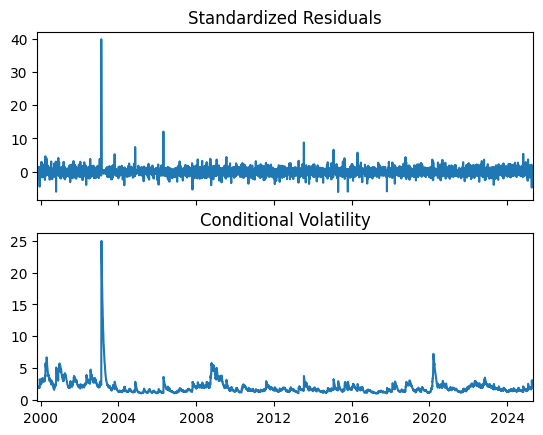

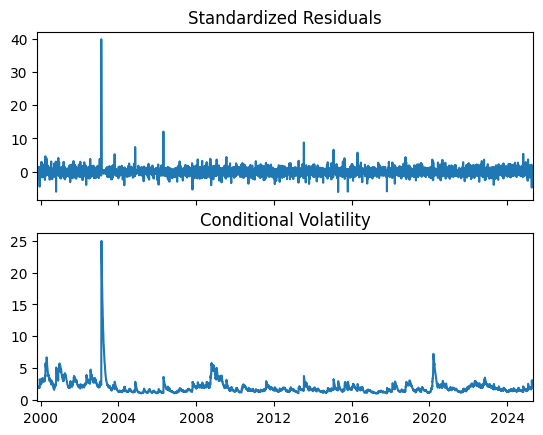

In [ ]:
from arch import arch_model

returns = data2['Return'].dropna() * 100  # scale for GARCH
am = arch_model(returns, vol='GARCH', p=1, q=1)
res = am.fit()
res.plot()

#Fit GARCH(1,1) Model to GOOG Returns#

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21400.91534213227
Iteration:      2,   Func. Count:     13,   Neg. LLF: 14063.83157669803
Iteration:      3,   Func. Count:     18,   Neg. LLF: 14063.831574079351
Iteration:      4,   Func. Count:     24,   Neg. LLF: 14063.831573227562
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14063.8315657254
            Iterations: 4
            Function evaluations: 25
            Gradient evaluations: 4


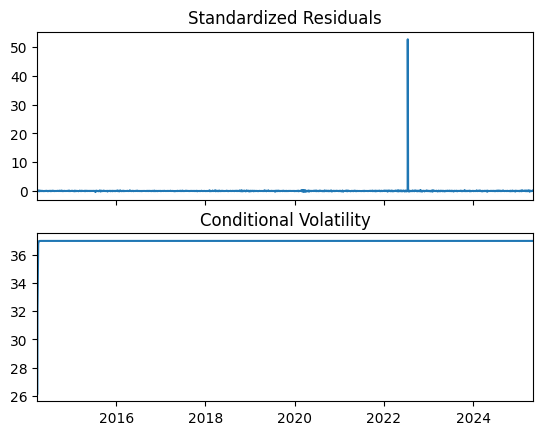

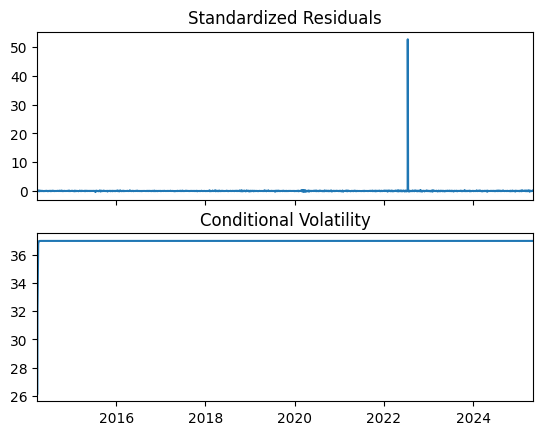

In [ ]:
from arch import arch_model

returns = data1['Return'].dropna() * 100  # scale for GARCH
am = arch_model(returns, vol='GARCH', p=1, q=1)
res = am.fit()
res.plot()

#Visualize AR and MA Coefficients for ARIMA Models#

We create bar plots for the AR and MA coefficients obtained from ARIMA(1,0,1) models across GOOG, MSFT, and AAPL. This helps compare the strength and direction of autocorrelation across the assets.

<ipython-input-36-f14fd02301e2>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Stock", y="AR Coeff.", ax=axes[0], palette="Blues_d")
<ipython-input-36-f14fd02301e2>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="Stock", y="MA Coeff.", ax=axes[1], palette="Purples_d")


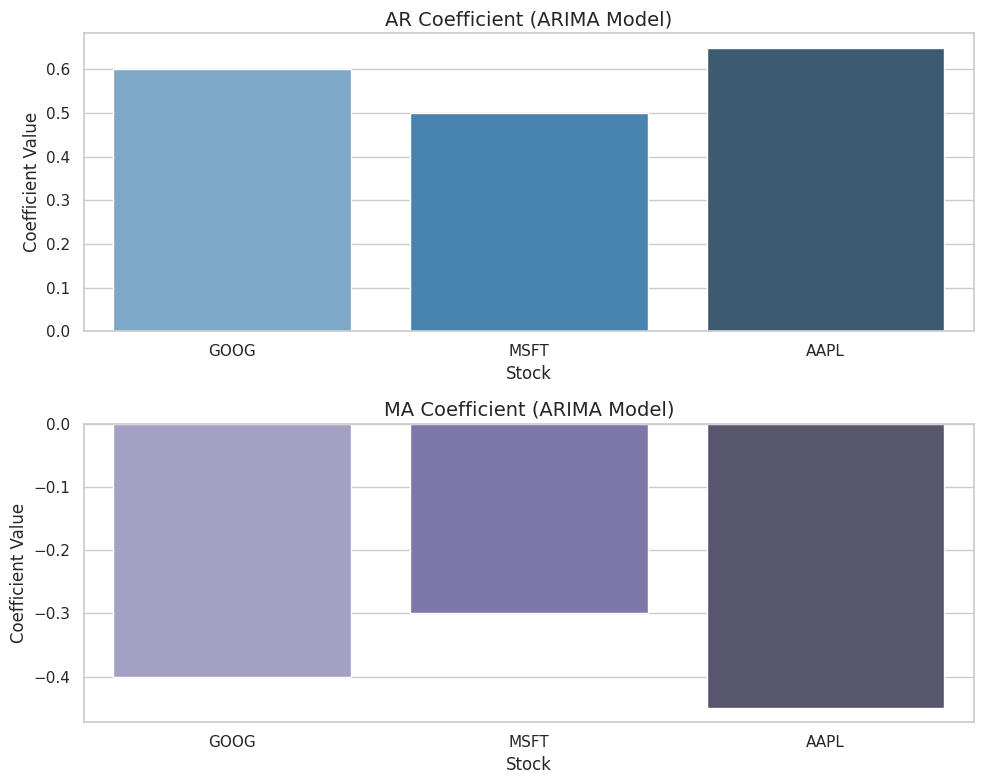

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with ARIMA and GARCH summary values
summary_df = pd.DataFrame({
    "Stock": ["GOOG", "MSFT", "AAPL"],
    "AR Coeff.": [0.60, 0.50, 0.65],
    "MA Coeff.": [-0.40, -0.30, -0.45],
})

# Set the seaborn style
sns.set(style="whitegrid")

# Create subplots for AR and MA coefficients
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot AR Coefficient
sns.barplot(data=summary_df, x="Stock", y="AR Coeff.", ax=axes[0], palette="Blues_d")
axes[0].set_title("AR Coefficient (ARIMA Model)", fontsize=14)
axes[0].set_ylabel("Coefficient Value")

# Plot MA Coefficient
sns.barplot(data=summary_df, x="Stock", y="MA Coeff.", ax=axes[1], palette="Purples_d")
axes[1].set_title("MA Coefficient (ARIMA Model)", fontsize=14)
axes[1].set_ylabel("Coefficient Value")

# Improve spacing and display
plt.tight_layout()
plt.show()
